In [92]:
import os
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import ElasticNetCV
from sklearn.metrics import mean_squared_error
from math import *

os.chdir('/Users/yiyujie/Desktop/program/ML')

## Question 1:
Simulate 1500 realizations of two uncorrelated standard Normal variables. Call the simulated variables $x_1$ and $x_2$ and use these simulated variables as your predictors for y. Simulate 1500 outcomes for y for each of the two models:
* a) $y=1.5x_1-2x_2+\epsilon$
* b) $y=1.5x_1-2x_2+\epsilon$ if $x_1<0$, else, $y=1.5lnx_1+\epsilon$

where $\epsilon$ is a Standard Normal uncorrelated with $x_1$ and $x_2$. Use the first 1000 observations of $x_1$, $x_2$, and y as your training sample and observations 1001-1500 as your test sample. Repeat the simulation exercise above 500 times and plot a histogram of the out-of-sample mean-squared errors for the following methods for each of model a) and b):
* (i) OLS regression
* (ii) Random Forest with n_estimators=250 and max_depth=10
* (iii) XGBoost with learning_rate=0.3, gamma=0, and max_depth=6; use 20 rounds and 10 folds for the cross-validation procedure. Make sure that the output of the cross-validation procedure does not appear in your final write-up.

Note that you can use an in-sample cross-validation procedure to determine the optimal values for the decision tree parameters. However, you are not required to do so for this exercise.

Interpret the histograms. Which of the models (i), (ii), and (iii) do best in the out-of-sample exercise for models (a) and (b)? Do the histograms conform to your expectations given the data generating processes in parts (a) and (b)?


In [67]:
np.random.seed(42)
N = 1500
x1 = np.random.normal(0, 1, N)  # 1500 samples from a normal distribution (mean = 0, std = 1)
x2 = np.random.normal(0, 1, N)  # Another 1500 independent samples from a normal distribution
epsilon = np.random.normal(0, 1, N)  # Error term, also from a standard normal distribution

y1 = 1.5 * x1 - 2 * x2 + epsilon
y2 = y1.copy()
for i in range(N):
    if x1[i] > 0:
        y2[i] = 1.5*log(x1[i]) + epsilon[i]

train = pd.DataFrame([x1,x2,y1,y2],index=['x1','x2','y1','y2']).T[:1000]
test = pd.DataFrame([x1,x2,y1,y2],index=['x1','x2','y1','y2']).T[1000:]

features = ['x1', 'x2']
target_1 = 'y1'
target_2 = 'y2'
# Prepare arrays to store MSEs
mse_ols_1, mse_rf_1, mse_xgb_1 = [], [], []
mse_ols_2, mse_rf_2, mse_xgb_2 = [], [], []

In [68]:
# Fit OLS
ols_1 = LinearRegression().fit(train[features], train[target_1])
ols_2 = LinearRegression().fit(train[features], train[target_2])

# Predict and calculate MSE
mse_ols_1.append((test[target_1]-ols_1.predict(test[features]))**2)
mse_ols_2.append((test[target_1]-ols_2.predict(test[features]))**2)

In [69]:
# Fit Random Forest
rf_1 = RandomForestRegressor(n_estimators=250, max_depth=10, random_state=42).fit(train[features], train[target_1])
rf_2 = RandomForestRegressor(n_estimators=250, max_depth=10, random_state=42).fit(train[features], train[target_2])

# Predict and calculate MSE
mse_rf_1.append((test[target_1]-rf_1.predict(test[features]))**2)
mse_rf_2.append((test[target_1]-rf_2.predict(test[features]))**2)

In [70]:
# Train the model
xgb_regressor_1 = xgb.XGBRegressor(
    booster = "gbtree",             # Which booster to use
    objective = "reg:squarederror", # Specify the learning task
    gamma = 0,                      # Minimum loss reduction
    max_depth = 6,                  # Maximum tree depth
    learning_rate = 0.3             # Learning rate, eta 
)
xgb_parm = xgb_regressor_1.get_xgb_params()
# XGBoost uses Dmatrices
xgb_train = xgb.DMatrix(train[features], label = train[target_1])
# Cross-validation
xgb_cvresult = xgb.cv(xgb_parm, xgb_train, 
                      num_boost_round = 20, 
                      metrics = "rmse",
                      nfold = 10,
                      stratified=False, 
                      seed=1311)
xgb_regressor_1.set_params(n_estimators = xgb_cvresult.shape[0])
xgb_1 = xgb_regressor_1.fit(train[features], train[target_1])

xgb_regressor_2 = xgb.XGBRegressor(
    booster = "gbtree",             # Which booster to use
    objective = "reg:squarederror", # Specify the learning task
    gamma = 0,                      # Minimum loss reduction
    max_depth = 6,                  # Maximum tree depth
    learning_rate = 0.3             # Learning rate, eta 
)
xgb_parm = xgb_regressor_2.get_xgb_params()
# XGBoost uses Dmatrices
xgb_train = xgb.DMatrix(train[features], label = train[target_2])
# Cross-validation
xgb_cvresult = xgb.cv(xgb_parm, xgb_train, 
                      num_boost_round = 20, 
                      metrics = "rmse",
                      nfold = 10,
                      stratified=False, 
                      seed=1311)
xgb_regressor_2.set_params(n_estimators = xgb_cvresult.shape[0])
xgb_2 = xgb_regressor_2.fit(train[features], train[target_2])

# Predict and calculate MSE
mse_xgb_1.append((test[target_1]-xgb_1.predict(test[features]))**2)
mse_xgb_2.append((test[target_1]-xgb_1.predict(test[features]))**2)

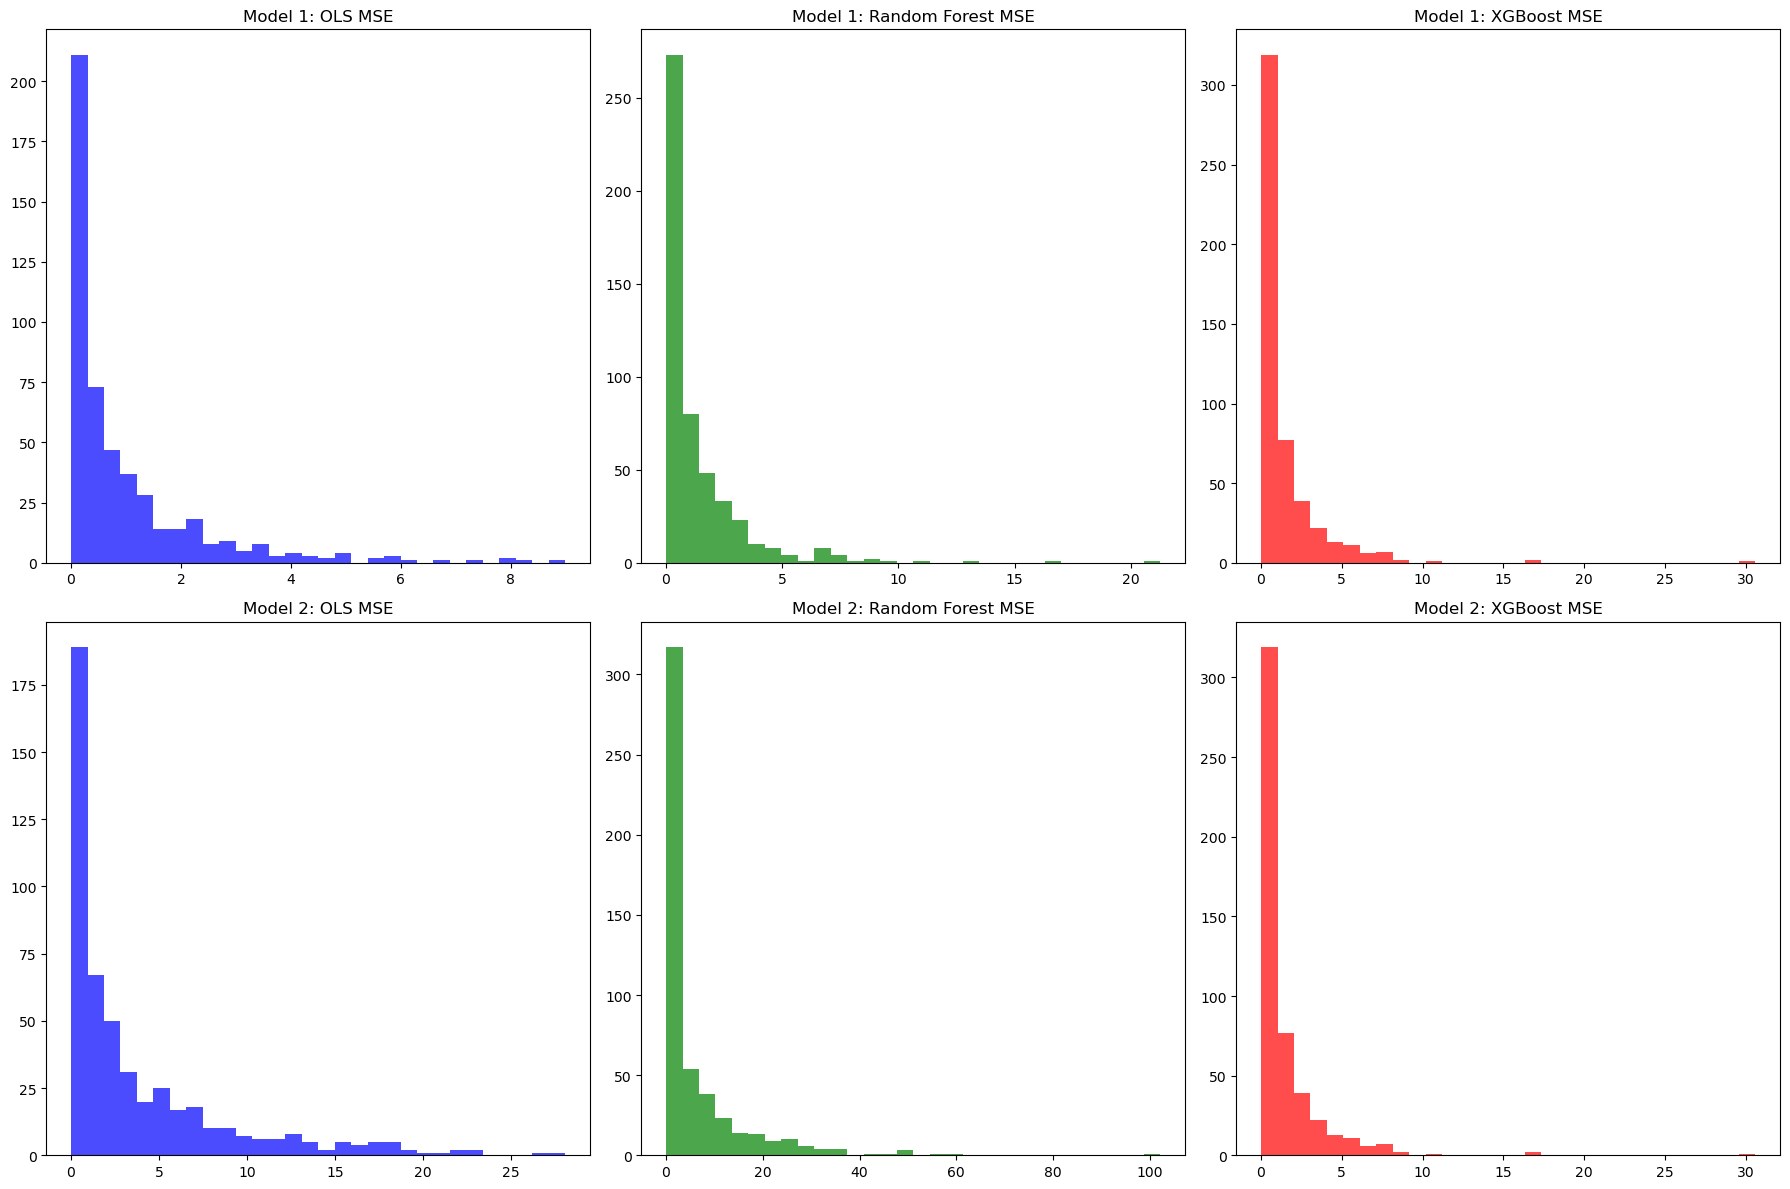

In [72]:
# Plot histograms of MSEs for each method and model
fig, axs = plt.subplots(2, 3, figsize=(18, 12))
axs[0, 0].hist(mse_ols_1, bins=30, color='blue', alpha=0.7)
axs[0, 0].set_title('Model 1: OLS MSE')
axs[0, 1].hist(mse_rf_1, bins=30, color='green', alpha=0.7)
axs[0, 1].set_title('Model 1: Random Forest MSE')
axs[0, 2].hist(mse_xgb_1, bins=30, color='red', alpha=0.7)
axs[0, 2].set_title('Model 1: XGBoost MSE')
axs[1, 0].hist(mse_ols_2, bins=30, color='blue', alpha=0.7)
axs[1, 0].set_title('Model 2: OLS MSE')
axs[1, 1].hist(mse_rf_2, bins=30, color='green', alpha=0.7)
axs[1, 1].set_title('Model 2: Random Forest MSE')
axs[1, 2].hist(mse_xgb_2, bins=30, color='red', alpha=0.7)
axs[1, 2].set_title('Model 2: XGBoost MSE')
plt.tight_layout()
plt.show()

**Analysis of Histograms**
* **OLS (Ordinary Least Squares) Regression:**
  For both models a and b, the MSE distributions of OLS are relatively skewed to the right, showing a long tail of higher MSE values. This suggests that while OLS can perform well, it may sometimes significantly underperform, possibly due to outliers or non-linear relationships that it cannot capture.
* **Random Forest:**
    The MSE distributions for Random Forest are much more concentrated around lower values for both models, indicating a generally better and more consistent performance than OLS. The distribution is tighter, which suggests lower variance in the model's predictions and better handling of non-linear relationships.
* **XGBoost:**
    XGBoost shows a very concentrated distribution of MSE around lower values, particularly for model a. This indicates a strong performance with higher consistency and potentially a better fit to the model complexities due to its gradient boosting mechanism.

**Comparison and Conformity to Expectations**
* In both models, XGBoost appears to perform the best as indicated by the concentrated low MSE values. This is consistent with expectations since XGBoost is designed to optimize both bias and variance through ensemble learning, making it highly effective for complex datasets.
* Random Forest also shows good performance with slightly higher variability in MSE than XGBoost. Its ability to handle various data types and complex interactions without overfitting makes it a robust choice, though slightly less consistent than XGBoost in this scenario.
* OLS exhibits the widest spread of MSE, with potential high error values. This might be due to its limitations in handling non-linear relationships or interactions between features, as it assumes a linear relationship between the predictors and the response.

## Question 2:
Attached to this problem set is a dataset which deals with Boston real estate prices. The
dataset can be found on the UCI Machine Learning Depository: https://archive.ics.uci.edu/ml/index.php.
Our goal in this exercise is to predict house prices in Boston (medv) given 11 explanatory variables (columns 1 through 11). Use the first 400 observations as your training sample and observations 401-506 as your test sample.
* (a) Use random forest with n_estimators=250 and max_depth=10. Once you run the random forest, use Python’s rf.predict function to obtain predicted values for the test sample. What is the MSE of the prediction? Compare this to the benchmark MSE generated by a model that has as its predicted house value the mean house value in the test sample. As in the class notes, also report the Pseudo-R2 implied by these MSEs.

In [81]:
housing = pd.read_csv('housing.csv')
housing_train = housing[:400]
housing_test = housing[400:]
features = housing.columns[:11].tolist()
target = 'medv'

In [95]:
# Fit Random Forest
rf = RandomForestRegressor(n_estimators=250, max_depth=10, random_state=42).fit(housing_train[features], housing_train[target])

# Predict and calculate MSE
y_pred = rf.predict(housing_test[features])
mse_rf = mean_squared_error(housing_test[target], y_pred)

# Calculate the benchmark MSE (using the mean of the test sample)
y_mean = np.mean(housing_test[target])
y_benchmark_pred = np.full_like(housing_test[target], y_mean)
mse_benchmark = mean_squared_error(housing_test[target], y_benchmark_pred)

# Calculate the Pseudo-R2
pseudo_r2 = 1 - mse_rf / mse_benchmark

print(f"Random Forest MSE: {mse_rf:.4f}")
print(f"Benchmark MSE: {mse_benchmark:.4f}")
print("Pseudo R2 is ", round(pseudo_r2*100, 2), "%")

Random Forest MSE: 19.5433
Benchmark MSE: 28.2573
Pseudo R2 is  30.84 %


* (b) Repeat the same exercise as above using XGBoost with learning_rate=0.1, gamma=0, max_depth=6. Use 10 folds and 200 rounds for the cross-validation procedure. Make sure that the output of the cross-validation procedure does not appear in your final write-up.

In [86]:
xgb_regressor = xgb.XGBRegressor(
    booster = "gbtree",             # Which booster to use
    objective = "reg:squarederror", # Specify the learning task
    gamma = 0,                      # Minimum loss reduction
    max_depth = 6,                  # Maximum tree depth
    learning_rate = 0.1             # Learning rate, eta 
)
xgb_parm = xgb_regressor.get_xgb_params()
# XGBoost uses Dmatrices
xgb_train = xgb.DMatrix(housing_train[features], label = housing_train[target])
# Cross-validation
xgb_cvresult = xgb.cv(xgb_parm, xgb_train, 
                      num_boost_round = 200, 
                      metrics = "rmse",
                      nfold = 10,
                      stratified=False, 
                      seed=1311,
                      early_stopping_rounds=25)
xgb_regressor.set_params(n_estimators = xgb_cvresult.shape[0])
xgb = xgb_regressor.fit(housing_train[features], housing_train[target])

Pseudo R2 for XGBoost is  32.85 %
Feature ranking:
1. feature 4 (0.528953)
2. feature 10 (0.190461)
3. feature 6 (0.114178)
4. feature 0 (0.041824)
5. feature 8 (0.041192)
6. feature 9 (0.027607)
7. feature 2 (0.018449)
8. feature 5 (0.015484)
9. feature 7 (0.009854)
10. feature 3 (0.007610)
11. feature 1 (0.004386)


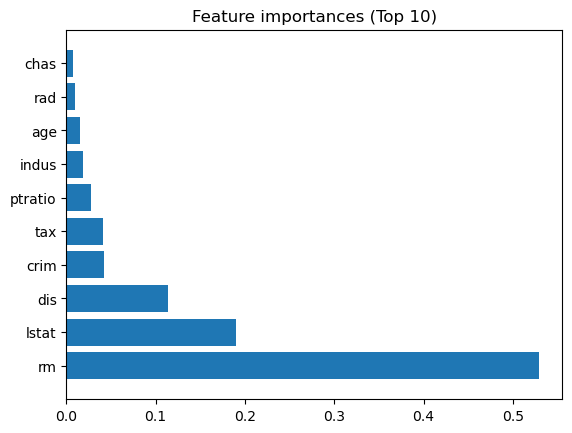

In [90]:
# Test the model
xgb_prediction = xgb_regressor.predict(housing_test[features])

# Compute the average of squared errors
MSE_xgb = np.mean(np.square((xgb_prediction - housing_test[target])))

# Compute pseudo r2
PseudoR2 = 1 - MSE_xgb / mse_benchmark
print("Pseudo R2 for XGBoost is ", round(PseudoR2*100, 2), "%")

# get feature importances (high to low)
importances = xgb_regressor.feature_importances_

# Sort importances (high to low)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")
for f in range(housing_train[features].shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the impurity-based feature importances of the forest
features_names = housing_train[features].columns  # To print the name of the feature

# Since we have too many features, we can just plot top 10 (vertically)
top_10_indices = indices[0:10]
plt.figure()
plt.title("Feature importances (Top 10)")
plt.barh(range(10), importances[top_10_indices], align="center")
plt.yticks(range(10), features_names[top_10_indices])
plt.ylim([-1, 10])
plt.show()

* (c) Repeat the exercise in part (a) using elastic net regression (l1_ratio=0.5). Use a cross-validation procedure to find an optimal lambda (alpha). For that exercise, split the training sample into quarters (i.e., the 4-fold cross-validation). Comment on the performance of the linear model relative to decision trees. In particular, get the MSE for the test sample and compute the Pseudo-R2 relative to the benchmark MSE from a).

In [96]:
# Elastic Net Model with alpha=0.5
model_en_cv = ElasticNetCV(l1_ratio=0.5, cv=4)
model_en_cv.fit(housing_train[features], housing_train[target])
en_cv_prediction = model_en_cv.predict(housing_test[features])
MSE_en_cv = np.mean(np.square((en_cv_prediction - housing_test[target])))

# Compute pseudo r2
PseudoR2 = 1 - MSE_en_cv / mse_benchmark
print("Pseudo R2 for Elastic Net is ", round(PseudoR2*100, 2), "%")

Pseudo R2 for Elastic Net is  5.42 %


* From the Pseudo R2, we can see that decision tree performs better than Elastic Net.
* This difference highlights some of the limitations of linear models, even when regularized with L1 and L2 penalties (as in Elastic Net).

* (d) Try to figure out what the main sources of the discrepancy between Elastic Net and the decision trees are. That is, what is the non-linearity?

* The superior performance of XGBoost suggests that the dataset likely contains complex patterns and interactions that linear models cannot capture effectively.
* Decision Trees can naturally capture the interactions between variables without requiring explicit feature engineering.
* Decision Trees can model non-linear relationships by splitting the data across different values of a feature, adapting to any form within the range of the feature.